# Lesson 2: Cleaning and Merging

[Previous Lesson](01-Requirements-Data-Identification.ipynb) [Next Lesson](03-Exploration.ipynb)

## Contents

* [Lesson 2: Cleaning and Merging](#Lesson-2:-Cleaning-and-Merging)
	* [Contents](#Contents)
	* [Getting Started](#Getting-Started)
	* [Loading, Merging, and Cleaning Similar Data](#Loading,-Merging,-and-Cleaning-Similar-Data)
		* [Loading a CSV: Franklin County Auditor Data](#Loading-a-CSV:-Franklin-County-Auditor-Data)
		* [Parsing Errors: Licking County Auditor Data](#Parsing-Errors:-Licking-County-Auditor-Data)
		* [Extraction from a GIS Dataset: Fairfield County Auditor Data](#Extraction-from-a-GIS-Dataset:-Fairfield-County-Auditor-Data)
	* [Joining Related Datasets](#Joining-Related-Datasets)
	* [Next Steps](#Next-Steps)
	* [Resources](#Resources)
    
    
### Questions

[1](#Lab-1), [2](#Lab-2), [3](#Lab-3), [4](#Lab-4), [5](#Lab-5), [6](#Lab-6), [7](#Lab-7), [8](#Lab-8), [9](#Lab-9),  [10](#Lab-10), [11](#Lab-11), [12](#Lab-12)

## Getting Started

In addition to libaries we used in the last lesson, this notebook relies on the [GeoPandas](library) to process data from a [geographic information system](https://en.wikipedia.org/wiki/Geographic_information_system).  To install the library, we can use `pip` and access it from the notebook using `!pip`. 

In [ ]:
!pip install geopandas

We'll be working with county auditor data containing real estate information.  To reduce the memory and time required to process the data, the size of one of the datasets was reduced; the *sample_file()* function below contains the code to do this. Two arguments are required when the function is called, *input_file* and *output_file*, to specify the source and target files, respectively.  An keyword argument, *fraction*, can be specified to set the desired size of the output file relative to the input file; the default value is 0.1.  

First, *sample_file()* calls *get_line_count()* to calculate the total number of lines in the source file. The total is multiplied by the specified fraction and truncated to the nearest integer to determine the number of lines that should be in the output file.  Next, the [*sample()*](https://docs.python.org/3/library/random.html#random.sample) function from the random module is used to select a sampling of line numbers from a range of values starting at 1 and ending at the last line number in the source file; the number of line numbers in the sample is equal to the calculated sample line count.  Finally, the function iterates through the source file, line-by-line, and copies a line to the output file if that line's line number is in the sample of line numbers.

The *sample_file()* function was used to reduce the Franklin County Auditor data from over 400,000 lines to about 40,000 lines.

In [ ]:
import linecache
import random

def get_line_count(input_file):
    """Count number of lines in a file"""
    count = 0
    with open(input_file) as infile:
        for line in infile:
            count += 1
    return count

def sample_file(input_file, output_file, fraction=0.1):
    """Exctract a subset of lines from a file"""
    total_line_count = get_line_count(input_file)
    sample_line_count = int(fraction * total_line_count)  # fraction of total
    sample_line_numbers = random.sample(range(1, total_line_count), 
                                        sample_line_count)  # sample of line numbers
    sample_line_numbers.sort()
    sample_line_numbers.insert(0, 0)
    with open(output_file, 'w') as outfile:
        for line_number in sample_line_numbers:
            line = linecache.getline(input_file, line_number + 1)
            outfile.write(line)
                    

## Loading, Merging, and Cleaning Similar Data

Often, the analysis we would like to complete requires gather data from multiple sources.  Working with multiple sources can present some challenges that should be addressed before analyzing the data.  Rather than keeping source data separate, its usually convenient to store similar data together - combining separate sources into one database table to similar data store. Combining sources require extracting relevant data and reorganizing it to fit the target structure.  

In addition to simply extracting the data, we often need to address data quality issues as well; examples of quality issues include

- *duplication*: the dataset unnecessarily includes repeated data
- *inconsistency*: different values are used to represent the same thing or the values do not fit the defined schema
- *incompleteness*: data is missing from the dataset
- *inaccuracy*: the data does not reflect what it purports to measure or represent

Resolving duplication issues is usually straightforward: duplicate data is removed before conducting further analysis. Inconsistencies can be resolved by determining the appropriate values and transforming the data as needed; however, realizing that multiple values correspond to the same thing might require some examination of the data.  While it can be easy to detect incompleteness of data, the approach for resolving the issue might be context-specific. Should a default value be used? Should a randomly generated value within some range be substituted? Should records with missing data be dropped entirely? Inaccuracies tend to be more difficult to detect and to resolve as they often require examining how the source data was collected.  

In the following examples, we'll work on aggregating data from three different county auditor datasets. Our immediate objective is to collect any data regarding appraisal values, sale price, total area, the number of rooms, information about heating and cooling, and the year built for residential properties. Later, we'll use this data to determine if there's a relationship between price or appraisal value and the other properties.

### Loading a CSV: Franklin County Audit Data

The first data source from which we'll extract data is a CSV containing [data from the Franklin County Auditor](ftp://apps.franklincountyauditor.com/). As noted above, the data as been sampled to reduce its size from 400,000 records to 40,000.  The Auditor's site provides documentation of the dataset.  Though the documentation appears to be outdated, it does provide some useful information.

In [1]:
# display auditor documentation in the notebook
from IPython.display import IFrame
IFrame("./data/02-franklin-description.pdf", 800, 600)

We can use the panda's *read_csv()* method to load the data.

In [2]:
# load data
import pandas as pd
franklin = pd.read_csv('./data/02-franklin.csv')

With the data loaded, we can now begin examining it. To start, we can see the complete list of columns in the dataset.  Compare this to the columns in the documentation - there are column names in the dataset that do not appear in the documentation and column names in the documentation that do not appear in the dataset.

In [3]:
franklin.columns.tolist()

['PID',
 'AEXMLND',
 'AEXMBLD',
 'AEXMTOT',
 'APPRLND',
 'APPRBLD',
 'APPRTOT',
 'AUDMAP',
 'AUDRTG',
 'LANDUSE',
 'CAUV',
 'SCHOOL',
 'HOMSTD',
 'MAILAD1',
 'MAILAD2',
 'MAILAD3',
 'MAILAD4',
 'TRANDT',
 'TRANYR',
 'NAME1',
 'NAME2',
 'NAME3',
 'OWNER_ADD1',
 'OWNER_ADD2',
 'NBRHD',
 'FLOOD',
 'PCLASS',
 'NOCARDS',
 'ACREA',
 'PRICE',
 'ANN_TAX',
 'STHNUM',
 'STCONT',
 'STHSFX',
 'STDIRE',
 'STNAME',
 'STSFX',
 'STADDR',
 'USPS_CITY',
 'STATE',
 'ZIPCODE',
 'DESCR1',
 'DESCR2',
 'DESCR3',
 'TAXDESI',
 'VALID',
 'AREA_A',
 'DWELTYP',
 'ROOMS',
 'BATHS',
 'HBATHS',
 'BEDRMS',
 'AIRCOND',
 'CINBRHD',
 'COND',
 'FIREPLC',
 'GRADE',
 'HEIGHT',
 'NOSTORY',
 'YEARBLT',
 'PROPTYP',
 'WALL',
 'TIFMLND',
 'TIFMBLD',
 'POINT_X',
 'POINT_Y']

We can view the first few rows using the DataFrame's *head()* method.  We'll increase the number of columns displayed to 200 to accommodate the datasets we'll be working with. 

In [4]:
pd.set_option('display.max_column', 200)
franklin.head()

,PID,AEXMLND,AEXMBLD,AEXMTOT,APPRLND,APPRBLD,APPRTOT,AUDMAP,AUDRTG,LANDUSE,CAUV,SCHOOL,HOMSTD,MAILAD1,MAILAD2,MAILAD3,MAILAD4,TRANDT,TRANYR,NAME1,NAME2,NAME3,OWNER_ADD1,OWNER_ADD2,NBRHD,FLOOD,PCLASS,NOCARDS,ACREA,PRICE,ANN_TAX,STHNUM,STCONT,STHSFX,STDIRE,STNAME,STSFX,STADDR,USPS_CITY,STATE,ZIPCODE,DESCR1,DESCR2,DESCR3,TAXDESI,VALID,AREA_A,DWELTYP,ROOMS,BATHS,HBATHS,BEDRMS,AIRCOND,CINBRHD,COND,FIREPLC,GRADE,HEIGHT,NOSTORY,YEARBLT,PROPTYP,WALL,TIFMLND,TIFMBLD,POINT_X,POINT_Y
0,010-020705,0.0,0.0,0.0,8100.0,59600.0,67700.0,D013,10.0,520,0.0,2503,NaN,MIDWEST LOAN SERVICES,NaN,616 SHELDEN AVE STE 300,HOUGHTON MI 49931-1841,3/22/2016 0:00:00,2016.0,NORRIS ROBIN R,HUGO ROBIN,NaN,246 ELDON AVE,COLUMBUS OH 43204,94.0,NaN,R,1.0,0.0,0.0,1455.02,244.0,-,246.0,N,ELDON,AV,244 - 246 N ELDON AV,COLUMBUS,OH,43204.0,244-6 ELDON AVE,HILL CREST PARK,LOT 24,CITY OF COLUMBUS,N,2264,1.0,10,2,0,4,1,NaN,NaN,NaN,C,DUPLEX,20.0,1925.0,NaN,WD/ALUM/VINYL,0.0,0.0,1809670.02,714541.95
1,010-020716,0.0,0.0,0.0,4600.0,69800.0,74400.0,D021,11.0,510,0.0,2503,NaN,TINA L CALDWELL,JAMES P KLAUSMAN,189 ELDON AVE,COLUMBUS OH 43204-3706,4/16/1996 0:00:00,1996.0,CALDWELL TINA L,JAMES P KLAUSMAN,NaN,NaN,NaN,94.0,NaN,R,1.0,0.0,50000.0,1578.72,189.0,NaN,NaN,N,ELDON,AV,189 N ELDON AV,COLUMBUS,OH,43204.0,189 N ELDEN AVE,HILL CREST PARK,LOT 39,CITY OF COLUMBUS,Y,1835,1.0,7,1,1,4,1,NaN,NaN,1.0,C,OLD STYLE,20.0,1919.0,NaN,WD/ALUM/VINYL,0.0,0.0,1809445.97,714129.83
2,010-020713,0.0,0.0,0.0,4900.0,60600.0,65500.0,D013,18.0,510,0.0,2503,NaN,WELLS FARGO REAL ESTATE,MAC X2302-04D,1 HOME CAMPUS,DES MOINES IA 50328-0001,3/13/2015 0:00:00,2015.0,CROYLE STEVE V,NaN,NaN,202 ELDON AVE,COLUMBUS OH 43204,94.0,NaN,R,1.0,0.0,64000.0,1390.16,202.0,NaN,NaN,N,ELDON,AV,202 N ELDON AV,COLUMBUS,OH,43204.0,202 ELDON AVE,HILLCREST PK,LOT 32,CITY OF COLUMBUS,Y,1656,1.0,7,1,0,3,1,NaN,NaN,NaN,C,OLD STYLE,20.0,1925.0,NaN,WD/ALUM/VINYL,0.0,0.0,1809641.41,714204.64
3,010-020784,0.0,0.0,0.0,5800.0,0.0,5800.0,D004,12.0,510,0.0,2503,NaN,HUNTINGTON MORTGAGE CORP,NaN,PO BOX 182661,COLUMBUS OH 43218-2661,9/18/2006 0:00:00,2006.0,TERRY DAVID G,TERRY CONSTANCE E,NaN,2450 WESTWOOD DR,COLUMBUS OH 43204,94.0,NaN,R,NaN,0.0,134000.0,126.20,NaN,NaN,NaN,NaN,WESTWOOD,DR,WESTWOOD DR,COLUMBUS,OH,43204.0,N S WESTWOOD DR,HILLCREST PARK,LOT 124,CITY OF COLUMBUS,Y,0,NaN,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1809302.85,715262.74
4,010-020773,0.0,0.0,0.0,5000.0,31200.0,36200.0,D004,8.0,510,0.0,2503,NaN,CHRISTOPHER M SNAPP,NaN,6448 SHARON WOODS BLVD,COLUMBUS OH 43229-2072,10/21/2011 0:00:00,2011.0,SNAPP CHRISTOPHER M,NaN,NaN,351 ELDON AVE,COLUMBUS OH 43204,94.0,NaN,R,1.0,0.0,0.0,768.12,351.0,NaN,NaN,NaN,ELDON,AV,351 ELDON AV,COLUMBUS,OH,43204.0,351 ELDEN AVE,HILLCREST PARK,LOT 113,CITY OF COLUMBUS,N,1000,1.0,5,1,0,2,1,NaN,NaN,NaN,C-1,RANCH,10.0,1922.0,NaN,WD/ALUM/VINYL,0.0,0.0,1808870.83,715286.02


Examining these rows, we can get a sense of the type of data in each column.  We can also see that some values are `NaN` which stands for "Not a Number" and is used when no value is present, i.e. when data is missing.  We'll address these values later.

As noted earlier, we'd like to extract appraisal value, sale price, and other data for residential real estate.  Based on the documentation, the `PCLASS` field should indicate a parcel's property class.  The first few rows of data are consistent with the documentation.  To see all the values that appear in the `PCLASS` field, we can use the *unique()* method for that column.

In [5]:
franklin.PCLASS.unique()

array(['R', 'C', 'E', 'I', nan, 'Z', 'A'], dtype=object)

We can also see the number of records with each value using the *value_counts()* method.

In [6]:
franklin.PCLASS.value_counts()

R    37902
C     3094
E     1290
I      397
A      108
Z       45
Name: PCLASS, dtype: int64

The documentation indicates that the `PROPTYP` also includes property type information; however, the first five rows do not have values for this field.  

<hr>
<a name="Lab-1"></a><mark> **Lab 1** Using *unique()*  or *value_counts()* in the cell below, confirm that none of the rows have data for the `PROPTYP` field.</mark>

<hr>
Based on the documentation and the first few rows of data, we might be interested in extracting the following columns from the larger dataset.

- `APPRLND`: appraisal land value
- `APPRBLD`: appraisal building value
- `PCLASS`: property class
- `PRICE`: sales price
- `AREA_A`: building area
- `ROOMS`: total number of rooms
- `BATHS`: number of full bathrooms
- `HBATHS`: number of half bathrooms
- `BEDRMS`: number of bedrooms
- `AIRCOND`: heating and/or air conditioning
- `FIREPLC`: presence of a fireplace
- `YEARBLT`: the build year

To extract these columns, we'll first create a list containing their names then create a copy of the DataFrame consisting only of the columns.

In [7]:
# home properties or fields we can use to filter out data
franklin_columns = ['APPRLND', 'APPRBLD', 'PCLASS', 'PRICE', 'AREA_A', 'ROOMS','BATHS', 
                    'HBATHS', 'BEDRMS', 'AIRCOND', 'FIREPLC','YEARBLT']

# copy vs view
franklin_subset = franklin[franklin_columns].copy()

The data in `franklin_subset` is a copy of the source data.  We can manipulate the copy while leaving the full dataset unchanged.  This can be helpful if we make a mistake or need to see what a value might have been prior to manipulation. Alternatively, we could just reload the data whenever necessary.

The first thing we can do is remove data for non-residential properties.  As shown above, 37,902 records correspond to residential properties.  To filter the data, we can use a mask and bracket notation with the DataFrame.  The mask we'll need is one that evaluates to `True` when the value of `PCLASS` is `R`.

One we've filtered the data, we can drop the `PCLASS` column as it is no longer needed.  To do this, we'll use the DataFrame's *drop()* method and specify the column name and axis.  We'll specify an axis value of *1* to indicate that we'd like to drop a column as opposed to a value of *0* to drop a row. We'll also use the *inplace* keyword argument to indicate that we'd like to manipulate the DataFrame itself rather than to return a DataFrame with the dropped column.

In [8]:
# filter the data using a mask
franklin_subset = franklin_subset[franklin_subset.PCLASS == 'R']

# drop the PCLASS column
franklin_subset.drop(['PCLASS'], axis=1, inplace=True)

We can confirm that that the DataFrame has been filtered by comparing number of records in the `franklin_subset` DataFrame to the number of records in the `franklin` DataFrame.

<hr>
<a name="Lab-2"></a><mark> **Lab 2** In the cell below, use *len()* and a comparison operator to confirm that the number of records in the `franklin_subset` DataFrame is less than the number of records in the `franklin` DataFrames.</mark>

<hr>

Let's look at the the appraisal-related fields, `APPRLND` and `APPRBLD`.  From above, we know that that data in the `APPRBLD` field is stored as floating point numbers. We can use the *describe()* method to calculate some descriptive statistics for `APPRBLD`.

In [9]:
franklin_subset.APPRBLD.describe()

count    3.790200e+04
mean     1.128262e+05
std      1.015612e+05
min      0.000000e+00
25%      5.130000e+04
50%      9.340000e+04
75%      1.461000e+05
max      2.700000e+06
Name: APPRBLD, dtype: float64

Notice that the minimum value is zero.  Let's see how many records have a building appraisal value of zero. Because the data is stored as floating point numbers, we should be aware of the [issues](https://docs.python.org/3/tutorial/floatingpoint.html) related to floating point values.  If we choose to continue working with the data as floating point values, we can use the [NumPy *isclose()*](https://docs.scipy.org/doc/numpy/reference/generated/numpy.isclose.html) function to create a mask to compare values to zero.

In [10]:
len(franklin_subset[pd.np.isclose(franklin_subset.APPRBLD, 0)])

2858

As an alternative to working with floating point values, we can convert a column's datatype to `int` when appropriate.  Here, an integer would represent whole dollar amounts and would be meaningful; if decimals are used to record fractions of a dollar, we won't loose much information.  As a Series, each column has an *astype()* method that can be used to convert the column's type.  The method creates a copy so we have to reassign the DataFrame's column when doing the conversion.

In [11]:
franklin_subset['APPRBLD'] = franklin_subset.APPRBLD.astype(int)

Now that the data is stored as integers, we can make comparisons more directly using the standard operators.

In [12]:
len(franklin_subset[franklin_subset.APPRBLD == 0])

2858

Let's filter the data to include only the rows where the building appraisal value is greater than zero.

In [13]:
franklin_subset = franklin_subset[franklin_subset.APPRBLD > 0]

<hr>
<a name="Lab-3"></a><mark> **Lab 3** In the cell below, filter the `franklin_subset` DataFrame to exclude rows that have a `APPRLND` of zero.</mark>

In [14]:
franklin_subset['APPRLND'] = franklin_subset.APPRLND.astype(int)
franklin_subset = franklin_subset[franklin_subset.APPRLND > 0]

<hr>

To simplify comparisons and other analysis later, we might choose to combine the data related to number of bathrooms into on column.  Because the data currently distinguishes between full and half baths, we can calculate the total number of bathrooms as the sum of the value of `BATH` and half the value of `HBATHS`.  Note that this has the effect of counting two half-bathrooms as a full bathroom; while two half-bathrooms might effect price differently than a full bathroom, we'll effectively ignore any such effect.

<hr>
<a name="Lab-4"></a><mark> **Lab 4** The data type of the `HBATH` and `HBATHS` should a numeric type (an integer or a floating point value) in order to calculate the combined value directly from the existing values.  In the cell below, use the `dtypes` property to confirm that the `HBATH` and `HBATHS` columns have a numeric data type.</mark>

<hr>

Rather than using a for loop and calculating net number of bathrooms for each row, pandas supports element-wise multiplication and addition allowing use to do the following.  For this calculation we will treat missing data in the same was as a zero value.  To do this, we use the *fillna()* method for the appropriate column and specify the value we'd like to use in place of missing values - zero, in this case.

In [15]:
franklin_subset["Bathrooms"] = franklin_subset.BATHS.fillna(0) + 0.5 * franklin_subset.HBATHS.fillna(0)

This calculates the number of bathrooms as defined above and creates stores each row's value in a new column named `Bathrooms`.  

<hr>
<a name="Lab-5"></a><mark> **Lab 5** We no longer need the `BATHS` or `HBATHS` columns. In the cell below, use the *drop()* method to remove these columns from the `franklin_subset` DataFrame.</mark>

In [16]:
franklin_subset.drop(['BATHS', "HBATHS"], axis=1, inplace=True)

<hr>

Next, let's look at the `AIRCOND` column.  The documentation indicates that the field can take one of three values:

- 0: No heating or air conditioning
- 1: Heat
- 2: Air conditioning and heat

Let's compare this to the actual values in the dataset.

In [17]:
# unique values in aircond
franklin_subset.AIRCOND.unique()

array([1, 0])

As we can see the `AIRCOND` column doesn't contain any records with a value of 2.  At this point, we might contact the person responsible for maintaining the data for clarification.  For our work, we'll that all residential parcels in the dataset have heat and `AIRCOND` here indicates whether or not air conditioning is available.  We can change the data type of the column to reflect this.  

In [18]:
franklin_subset.AIRCOND = franklin_subset.AIRCOND.astype('bool')

Moving on to to the `FIREPLC` column, we can list the unique values to see that the dataset is again inconsistent with the documentation; rather than containing a single character representing the presence or absence of a fireplace the dataset instead contains integer values that likely indicate the number of fireplaces installed.

In [19]:
franklin_subset.FIREPLC.unique()

array([nan,  1.,  4.,  2.,  3.,  0.,  5.,  6.,  7.])

We can see that `nan` is among the values.  

<hr>
<a name="Lab-6"></a><mark> **Lab 6** In the cell below, use the *fillna* property with the `FIREPLC` column to replace missing values with zero.  Either reassign the DataFrame's `FIREPLC` column with modified data or specify `inplace=True` as an argument to *fillna()* to alter the column in-place.</mark>

In [20]:
franklin_subset.FIREPLC.fillna(value=0, inplace=True)

<hr>

At this point we have the following columns and data types.

In [21]:
franklin_subset.dtypes

APPRLND        int64
APPRBLD        int64
PRICE        float64
AREA_A         int64
ROOMS          int64
BEDRMS         int64
AIRCOND         bool
FIREPLC      float64
YEARBLT      float64
Bathrooms    float64
dtype: object

Before moving on to the next dataset, it might be useful to give the columns more descriptive names.  First, let's create a copy of the DataFrame in case we need access to the data in its current state later.

In [138]:
home_data = franklin_subset.copy()

To rename the columns, we can use the DataFrame's *rename()* method. When calling the method, we can pass a dictionary that maps the existing column names to new names. We'll also specify that we want to change column names rather than index labels by specifying `axis=1` and that we'd like to alter the DataFrame itself rather than return a copy with the alteration using `inplace=True`.

In [139]:
home_data.rename(
    {'APPRLND': 'AppraisedLand',
     'APPRBLD': 'AppraisedBuilding',
     'PRICE': 'SalePrice',
     'AREA_A': 'Area', 
     'ROOMS':'Rooms',
     'BEDRMS':'Bedrooms',
     'AIRCOND': 'AirConditioning', 
     'FIREPLC': 'Fireplaces', 
     'YEARBLT': 'YearBuilt'
    },
    axis=1 ,
    inplace=True
)

<hr>
<a name="Lab-7"></a><mark> **Lab 7** In the cell below, verify that the columns of the `home_data` DataFrame have been changed.</mark>

<hr>

As noted above, we'd also like to record whether or not a parcel includes heating.  Earlier we assumed that all residential properties in the data set did include heating.  To add a column with the same value for each row, we can write a statement that assigns that value to the new column in the DataFrame.  Similarly, we'll add a `County` column to indicate the source of the data.

In [140]:
home_data['Heat'] = True
home_data['County'] = "Franklin"

We can view the first few rows to examine the state of our data before moving on to the next dataset.

In [141]:
home_data.head()

,AppraisedLand,AppraisedBuilding,SalePrice,Area,Rooms,Bedrooms,AirConditioning,Fireplaces,YearBuilt,Bathrooms,Heat,County
0,8100,59600,0.0,2264,10,4,True,0.0,1925.0,2.0,True,Franklin
1,4600,69800,50000.0,1835,7,4,True,1.0,1919.0,1.5,True,Franklin
2,4900,60600,64000.0,1656,7,3,True,0.0,1925.0,1.0,True,Franklin
4,5000,31200,0.0,1000,5,2,True,0.0,1922.0,1.0,True,Franklin
5,4600,63300,0.0,1306,6,4,True,0.0,1948.0,2.0,True,Franklin


### Parsing Errors: Licking County Auditor Data

We can augment the Franklin County Auditor data with data from the [Licking County Auditor](https://www.lickingcountyohio.us/).  The data we'll use was obtained directly from the auditor's site and was not sampled or modified.  Let's try loading the data stored in `data/02-licking.txt`.

In [26]:
licking = pd.read_csv("./data/02-licking.txt")

ParserError: Error tokenizing data. C error: Expected 33 fields in line 3, saw 34


The exception indicates that there was a problem parsing the data; specifically, pandas expected 33 fields but found 34 on line 3.  This could be due to pandas incorrectly guessing what the delimiter is.  We could use the csv module's *Sniffer* class to detect the delimiter but visual inspection will suffice.

In the code below, we'll print the first five lines.

In [27]:
line_number = 0 
with open("./data/02-licking.txt") as infile:
    while line_number < 5:
        print(infile.readline())
        line_number += 1

fldParcelID;fldParcelNo;fldRoutingNo;fldOwner;fldCardNo;fldMaxCards;fldRecheck;fldSchoolDistrict;fldTaxDistrict;fldLegalDesc;fldLocationAddress;fldNeighborhood;fldPropertyType;fldLUC;fldTopo;fldAccess;fldUtilities;fldNotes;fldNotes2;fldMarketLand;fldMarketImprov;fldMarketTotal;fldCAUVLand;fldCAUVImprov;fldCAUVTotal;fldSketchPath;fldStyle;fldStories;fldExterior;fldHeating;fldCooling;fldBasement;fldFullBaths;fldHalfBaths;fldOtherBaths;fldAttic;fldAtticHeating;fldRooms;fldBedrooms;fldFamilyRooms;fldDiningRooms;fldLivingRooms;fldFinishedLivingArea;fldFinishedBasementArea;fldYearBuilt;fldEffYearBuilt;fldYearRemodeled;fldCondition;fldGrade;fldBasementGarage;fldFireplaceOpenings;fldFireplaceStacks;fldFirstFloorArea;fldFirstFloorCost;fldUpperFloorArea;fldUpperFloorCost;fldAtticArea;fldAtticCost;fldHalfFloorArea;fldHalfFloorCost;fldFinishedBasementCost;fldUnfinishedLivingArea;fldUnfinishedLivingCost;fldCrawlArea;fldCrawlCost;fldBasementArea;fldBasementCost;fldBasementGarageArea;fldBasementGarag

Examining the output, we can see that the delimiter is probably a semicolon rather than a comma.  The pandas *read_csv()* method takes a keyword argument, *delimiter*, that will allow us to specify the appropriate value.

In [28]:
licking = pd.read_csv("./data/02-licking.txt", delimiter=";")

ParserError: Error tokenizing data. C error: Expected 181 fields in line 1608, saw 182


The exception message indicates that pandas made it farther into the file before encountering an error.  On line 1608, it, pandas expected to find 181 fields based on the previous lines but instead found 182.  Let's investigate further.

While we could iterate through the file and collect the line or lines that are of interest to use, we can use the *linecache* module to access a specific line within a file.  The code below extracts a typical line (one that did not cause a parser error) and the line that causes a problem.  After extracting the lines, the code displays their content.

In [29]:
import linecache
typical_line = linecache.getline("./data/02-licking.txt", 2)
error_line = linecache.getline("./data/02-licking.txt", 1608)

display(typical_line)
display(error_line)

'35;001-000066-00.009;001-006.00-120.000;HARDY RONALD J & LINDA B;1;1;No;NORTHRIDGE LSD;001 - BENNINGTON T-NRDGE LSD;LOT 10 PT   3.68 AC;8713 BENNER RD;06700 Bennington-T;Dwelling;511 Single family unplatted 0-09.9;;;2578 Electric Gas Well Septic;;;50300;138100;188400;0;0;0;C:\\tempPRCsketch.bmp;Single Family;1;Frame;Central Warm Air;Central;Full Basement;2.0;;;None;;6.0;3.0;;0.0;;1,790;0;2002;2002;;Average;90;;;;1,790;115,400;0;0;0;0;0;0;0;0;0;0;0;1,790;30,600;0;0;;0;;0;;5,400;;4,500;S(0), O(0);0;1;1;;15,400;;0;171,300;90;-17,130;100;0;;;166,200;-33,240;No;20;0;0.00000;;133,000;5,100;138,100;Well/Septic;12,000;2016;2015;2014;41,300;41,300;41,300;141,500;141,500;141,500;182,800;182,800;182,800;06/07/2001;11/01/2000;07/06/1999;;1;4;4;;FD - FIDUCIARY;EX - EXEMPT CONVEYANCE;EX - EXEMPT CONVEYANCE;;32000.00;0.00;0.00;;01721     ;99999     ;99999     ;;Y;N;N;;Y;Y;Y;;BEVIER MARLENE M TRUSTEE;SHARROCK LORI S TRUSTEE;Refer to deed;;;50,300;5,100;15,400;2017;146,000;No;No;No;No;No;0;100;138,100

'14934;020-051654-00.000;020-116.18-017.000;FULLER JEAN A TRUSTEE;1;1;No;GRANVILLE EVSD;020 - GRANVILLE T - GRANVILLE V&EVSD;LOT 116;128 E BROADWAY;05500 Granville-Vil-West Half;Building;430 Resturant; cafteria and/or bar;;;6 All;;;165100;319900;485000;0;0;0;C:\\tempPRCsketch.bmp;;2;;;;;;;;;;;;;;;3,600;;;;;;;;;;1,800;115,400;1,800;83,500;0;0;0;0;0;0;0;0;0;0;0;0;0;;19,000;;0;;0;;0;S(0), O(0);0;1;1;;1,800;;0;219,700;110;21,970;100;0;;;241,700;-48,340;No;20;0;0.00000;;193,400;2,300;195,700;;0;2016;2015;2014;315,000;315,000;315,000;129,400;129,400;129,400;444,400;444,400;444,400;02/24/2010;11/28/2005;;;3;1;;;EX - EXEMPT CONVEYANCE;EX - EXEMPT CONVEYANCE;;;0.00;0.00;;;99999;99999     ;;;N;N;;;N;N;;;FULLER THOMAS T & JEAN A TRUSTEES;Refer to deed;;;;165,100;2,300;1,800;2017;198,900;No;No;No;No;No;0;100;195,700;0;0;0;0;195,700;;0.00;15612;;;;;No;100.00;;;FULLER JEAN A TRUSTEE;145 VILL EDGE DR ;GRANVILLE OH 43023-1446\n'

Printing the lines in their entirety isn't very revealing.  

<hr>
<a name="Lab-8"></a><mark> **Lab 8** A difference in the number of fields could be caused by a difference in the number of delimiters. In the cell below use the [*count()*](https://docs.python.org/3/library/stdtypes.html#str.count) method with each line to display the number of times the delimiter appears.</mark>

<hr>

It would be helpful if we could compare each fields values between the two lines.  To do this we'll use the String [*split()*](https://docs.python.org/3/library/stdtypes.html#str.split) method to separate each line into a list of field values.  In addition to the two lines we already have, we'll retrieve the first line from the data for column names.  We can use the itertools module's [zip_longest](https://docs.python.org/3/library/itertools.html#itertools.zip_longest) function to combine the list of values extracted from each line for comparison.  

In [30]:
from itertools import zip_longest

header_line = linecache.getline("./data/02-licking.txt", 1)

header_entries = header_line.split(";")
typical_entries = typical_line.split(";")
error_entries = error_line.split(";")

for entry in zip_longest(header_entries, typical_entries, error_entries):
    print(entry)

('fldParcelID', '35', '14934')
('fldParcelNo', '001-000066-00.009', '020-051654-00.000')
('fldRoutingNo', '001-006.00-120.000', '020-116.18-017.000')
('fldOwner', 'HARDY RONALD J & LINDA B', 'FULLER JEAN A TRUSTEE')
('fldCardNo', '1', '1')
('fldMaxCards', '1', '1')
('fldRecheck', 'No', 'No')
('fldSchoolDistrict', 'NORTHRIDGE LSD', 'GRANVILLE EVSD')
('fldTaxDistrict', '001 - BENNINGTON T-NRDGE LSD', '020 - GRANVILLE T - GRANVILLE V&EVSD')
('fldLegalDesc', 'LOT 10 PT   3.68 AC', 'LOT 116')
('fldLocationAddress', '8713 BENNER RD', '128 E BROADWAY')
('fldNeighborhood', '06700 Bennington-T', '05500 Granville-Vil-West Half')
('fldPropertyType', 'Dwelling', 'Building')
('fldLUC', '511 Single family unplatted 0-09.9', '430 Resturant')
('fldTopo', '', ' cafteria and/or bar')
('fldAccess', '', '')
('fldUtilities', '2578 Electric Gas Well Septic', '')
('fldNotes', '', '6 All')
('fldNotes2', '', '')
('fldMarketLand', '50300', '')
('fldMarketImprov', '138100', '165100')
('fldMarketTotal', '188400',

Compare the values for the `fldTopo` header.  The "typical line" has no value whereas the "error line" has a value that seems related to the value associated with the previous field, `fldLUC`.  If we look back to the the display of each line's content, we can see that "430 Resturant" and "cafeteria and/or bar" are separated by a semicolon but should be kept together rather than split apart as different field values; note that "Restaurant" is misspelled in the source data.  The source data should use quoting if a delimiter appears as part of a data value or avoid using the delimiter in such a capacity.

Now that we know what the problem is, there are a variety of ways to address the problem.  One way is to replace all instances of "430 Restaurant; cafeteria and/or bar" in the source text with something that doesn't have a semicolon prior to loading it in pandas.  In the code below, we assign the problematic value and its replacement value to variables.  After reading the content of the file, we use the *replace()* method to substitute occurrences of the first value with the second. We then load the data into pandas.  Because the pandas *read_csv()* function is expecting a file or stream, and not a string or bytes, we use the [*StringIO*](https://docs.python.org/3/library/io.html#io.StringIO) class to create a stream from the altered content. We specify "python" as the *engine* in the *read_csv()* method to avoid warnings about memory.

In [31]:
import io 
old_value = "430 Resturant; cafteria and/or bar"
new_value = "430 Resturant, cafeteria and/or bar"

with open("./data/02-licking.txt") as infile:
    content = infile.read()
    
content = content.replace(old_value, new_value)
    
licking = pd.read_csv(io.StringIO(content), delimiter=";", engine="python")

While this was relatively straightforward, there are disadvantages to this method.  The primary disadvantage here is that we iterate through the content of the file several times: first we read all the content, then we iterate through it to find and replace the problematic value, then iterate through it to load it into pandas; usually we only iterate through the file once when loading it into pandas.  While this is fine for relatively small files, we should avoid looping through the entirety of a file whenever possible.

An alternative method would be to make use of pandas' support for [regular expressions](https://docs.python.org/3.2/library/re.html) when specifying the delimiter. We can use a [negative look-behind assertion](https://www.regular-expressions.info/lookaround.html) to indicate that a delimiter is any semicolon that isn't immediately preceded by the string "Resturant".  We could do this with the following call to *read_csv()*:

```python
licking = pd.read_csv("./data/02-licking.txt", delimiter="(?<!Resturant);", engine="python")
```

With the data loaded, let's display the first few lines to get sense of the data.

In [32]:
licking.head()

,fldParcelID,fldParcelNo,fldRoutingNo,fldOwner,fldCardNo,fldMaxCards,fldRecheck,fldSchoolDistrict,fldTaxDistrict,fldLegalDesc,fldLocationAddress,fldNeighborhood,fldPropertyType,fldLUC,fldTopo,fldAccess,fldUtilities,fldNotes,fldNotes2,fldMarketLand,fldMarketImprov,fldMarketTotal,fldCAUVLand,fldCAUVImprov,fldCAUVTotal,fldSketchPath,fldStyle,fldStories,fldExterior,fldHeating,fldCooling,fldBasement,fldFullBaths,fldHalfBaths,fldOtherBaths,fldAttic,fldAtticHeating,fldRooms,fldBedrooms,fldFamilyRooms,fldDiningRooms,fldLivingRooms,fldFinishedLivingArea,fldFinishedBasementArea,fldYearBuilt,fldEffYearBuilt,fldYearRemodeled,fldCondition,fldGrade,fldBasementGarage,fldFireplaceOpenings,fldFireplaceStacks,fldFirstFloorArea,fldFirstFloorCost,fldUpperFloorArea,fldUpperFloorCost,fldAtticArea,fldAtticCost,fldHalfFloorArea,fldHalfFloorCost,fldFinishedBasementCost,fldUnfinishedLivingArea,fldUnfinishedLivingCost,fldCrawlArea,fldCrawlCost,fldBasementArea,fldBasementCost,fldBasementGarageArea,fldBasementGarageCost,fldExtWallArea,fldExtWallCost,fldHeatingArea,fldHeatingCost,fldCoolingArea,fldCoolingCost,fldPlumbingArea,fldPlumbingCost,fldFireplaceArea,fldFireplaceCost,fldIdenticalMultiplierCount,fldIdenticalMultiplierCost,fldEnhancementArea,fldEnhancementCost,fldFeaturesArea,fldFeaturesCost,fldSubTotalBeforeGrade,fldGradeArea,fldGradeCost,fldCostFactorArea,fldCostFactorCost,fldUngradedFeaturesArea,fldUngradedFeaturesCost,fldRCN,fldDepreciation,fldDepreciationOverride,fldDepreciationArea,fldObsolesence,fldObsolesenceArea,fldImprovements,fldRCNLD,fldImprovementsTotal,fldFVC,fldWellSeptic,fldWellSepticValue,fldValueHistoryYear1,fldValueHistoryYear2,fldValueHistoryYear3,fldValueHistoryLand1,fldValueHistoryLand2,fldValueHistoryLand3,fldValueHistoryImprov1,fldValueHistoryImprov2,fldValueHistoryImprov3,fldValueHistoryTotal1,fldValueHistoryTotal2,fldValueHistoryTotal3,fldSalesDate1,fldSalesDate2,fldSalesDate3,fldSalesDate4,fldSalesNoParcels1,fldSalesNoParcels2,fldSalesNoParcels3,fldSalesNoParcels4,fldSalesType1,fldSalesType2,fldSalesType3,fldSalesType4,fldSalesPrice1,fldSalesPrice2,fldSalesPrice3,fldSalesPrice4,fldSalesConveyance1,fldSalesConveyance2,fldSalesConveyance3,fldSalesConveyance4,fldSalesValid1,fldSalesValid2,fldSalesValid3,fldSalesValid4,fldSalesLandOnly1,fldSalesLandOnly2,fldSalesLandOnly3,fldSalesLandOnly4,fldSalesPrevOwner1,fldSalesPrevOwner2,fldSalesPrevOwner3,fldSalesPrevOwner4,fldFeatureTotal,fldLandTotal,fldImprovTotal,fldEnhancementTotal,fldTaxYear,fldSubtotal,fldAdditionalInspections,fldAdditionalEnhancements,fldAdditionalFeatures,fldAdditionalLand,fldAdditionalImprovements,fldNeighAdj,fldNeighAdjArea,fldCard1Total,fldCard2Total,fldCard3Total,fldCard4Total,fldCard5Total,fldParcelTotal,fldPicPath,fldAcreageTotal,fldSortOrder,fldCropTotal,fldWoodsTotal,fldNotFarmedTotal,fldConservationTotal,fldNeighAdjLandOverride,fldNeighAdjAreaLand,fldMailingAddress1,fldMailingAddress2,fldMailingAddress3,fldMailingAddress4,fldMailingAddress5
0,35,001-000066-00.009,001-006.00-120.000,HARDY RONALD J & LINDA B,1,1,No,NORTHRIDGE LSD,001 - BENNINGTON T-NRDGE LSD,LOT 10 PT 3.68 AC,8713 BENNER RD,06700 Bennington-T,Dwelling,511 Single family unplatted 0-09.9,NaN,NaN,2578 Electric Gas Well Septic,NaN,NaN,50300.0,138100.0,188400.0,0.0,0.0,0.0,C:\tempPRCsketch.bmp,Single Family,1,Frame,Central Warm Air,Central,Full Basement,2.0,NaN,NaN,None,NaN,6.0,3.0,NaN,0.0,NaN,"1,790",0.0,2002.0,2002.0,NaN,Average,90.0,NaN,NaN,NaN,"1,790","115,400",0,0,0,0,0,0,0,0,0.0,0,0,"1,790","30,600",0.0,0,NaN,0,NaN,0,NaN,"5,400",NaN,"4,500","S(0), O(0)",0,1.0,1.0,NaN,"15,400",NaN,0,"171,300",90.0,"-17,130",100.0,0,NaN,NaN,"166,200","-33,240",No,20.0,0.0,0.0,NaN,"133,000","5,100","138,100",Well/Septic,"12,000",2016.0,2015.0,2014.0,"41,300","41,300","41,300","141,500","141,500","141,500","182,800","182,800","182,800",06/07/2001,11/01/2000,07/06/1999,NaN,1.0,4.0,4.0,NaN,FD - FIDUCIARY,EX - EXEMPT CONVEYANCE,EX - EXEMPT CONVEYANCE,NaN,32000.0,0.0,0.0,NaN,01721,99999,99999,NaN,Y,N,N,NaN,Y,Y,Y,

As with the Franklin country dataset, we'd like to filter this dataset for only residential buildings.  Unfortunately, there isn't documentation available to describe the content of each column so we'll have to do our best to infer meaning from the column name and values. Looking at the data above, it looks like `fldPropertyType` or `fldStyle` might be useful to determine which properties are residential and which are not.

In [33]:
licking.fldPropertyType.unique()

array(['Dwelling', 'Other', nan, 'Building'], dtype=object)

In [34]:
licking.fldStyle.unique()

array(['Single Family', nan, 'MFD Home', 'Tri-Level', 'Duplex',
       'Bi-Level', 'Multi-Level', 'Condominum', 'Mobile Home',
       'Commercial', 'Exempt', '4-6 Family', 'Conversion', 'Apartment',
       'Triplex', '4-Level'], dtype=object)

It looks like most of style values are related to residential-type properties.  At this point, we might decide to choose specific styles to filter on or choose to simply exclude records without style information or those that correspond to a commercial style.  

Let's see the styles associated with the *Dwelling* property type.  

In [35]:
licking[licking.fldPropertyType == 'Dwelling'].fldStyle.unique()

array(['Single Family', 'MFD Home', 'Tri-Level', 'Duplex', nan,
       'Bi-Level', 'Multi-Level', 'Condominum', 'Mobile Home',
       'Commercial', 'Exempt', '4-6 Family', 'Conversion', 'Apartment',
       'Triplex', '4-Level'], dtype=object)

Filter the data to include only the *Dwelling* property didn't reduce the number of styles.  For this example, we'll filter the data to include only *Single Family*, *MFD Home*, *Tri-Level*, *Duplex*, *Bi-Level*, *Multi-Level*, *Condominum*, *Mobile Home*, *Triplex*, and *4-Level*.  Note that *Condominum* is misspelled in the source data.

We can create a list of acceptable style values now that can be used to filter the data later.

In [36]:
licking_styles = ['Single Family', 'MFD Home', 'Tri-Level', 'Duplex',
                     'Bi-Level', 'Multi-Level', 'Condominum', 'Mobile Home',
                     'Triplex', '4-Level']

Let's consider the other columns we'll need.  We had collected sales price data from the Franklin county dataset.  In this dataset, there are quite a few columns with "sales" in the name.

In [37]:
[column for column in licking.columns if "sales" in column.lower()]

['fldSalesDate1',
 'fldSalesDate2',
 'fldSalesDate3',
 'fldSalesDate4',
 'fldSalesNoParcels1',
 'fldSalesNoParcels2',
 'fldSalesNoParcels3',
 'fldSalesNoParcels4',
 'fldSalesType1',
 'fldSalesType2',
 'fldSalesType3',
 'fldSalesType4',
 'fldSalesPrice1',
 'fldSalesPrice2',
 'fldSalesPrice3',
 'fldSalesPrice4',
 'fldSalesConveyance1',
 'fldSalesConveyance2',
 'fldSalesConveyance3',
 'fldSalesConveyance4',
 'fldSalesValid1',
 'fldSalesValid2',
 'fldSalesValid3',
 'fldSalesValid4',
 'fldSalesLandOnly1',
 'fldSalesLandOnly2',
 'fldSalesLandOnly3',
 'fldSalesLandOnly4',
 'fldSalesPrevOwner1',
 'fldSalesPrevOwner2',
 'fldSalesPrevOwner3',
 'fldSalesPrevOwner4']

Looking at the sample data above, we will likely be interested in the collection of `fldSalesPrice` columns to determine the sales price. Let's look at the values of these columns for a small number of rows.

In [38]:
licking[['fldSalesPrice1', 'fldSalesPrice2', 'fldSalesPrice3', 'fldSalesPrice4']].head(10)

,fldSalesPrice1,fldSalesPrice2,fldSalesPrice3,fldSalesPrice4
0,32000.0,0.0,0.0,NaN
1,0.0,NaN,NaN,NaN
2,0.0,38900.0,53334.0,117000.0
3,0.0,0.0,210000.0,0.0
4,14919.0,NaN,NaN,NaN
5,144900.0,0.0,106000.0,NaN
6,180000.0,NaN,NaN,NaN
7,117000.0,139500.0,80000.0,72000.0
8,0.0,NaN,NaN,NaN
9,135000.0,0.0,47000.0,21000.0


We have nonzero, zero and `NaN` values.  In addition to these columns, the data also contains `fldSalesDate` columns. To get a better idea of what the prices represent, let's look at the date columns as well.

In [39]:
licking[['fldSalesPrice1', 'fldSalesPrice2', 'fldSalesPrice3', 'fldSalesPrice4', 
         'fldSalesDate1', 'fldSalesDate2', 'fldSalesDate3', 'fldSalesDate4']].head(10)

,fldSalesPrice1,fldSalesPrice2,fldSalesPrice3,fldSalesPrice4,fldSalesDate1,fldSalesDate2,fldSalesDate3,fldSalesDate4
0,32000.0,0.0,0.0,NaN,06/07/2001,11/01/2000,07/06/1999,NaN
1,0.0,NaN,NaN,NaN,09/18/2000,NaN,NaN,NaN
2,0.0,38900.0,53334.0,117000.0,08/17/2017,09/27/2012,02/23/2012,12/23/2003
3,0.0,0.0,210000.0,0.0,11/18/2013,04/10/2012,10/13/2006,10/13/2006
4,14919.0,NaN,NaN,NaN,01/14/2005,NaN,NaN,NaN
5,144900.0,0.0,106000.0,NaN,05/05/2010,10/19/2004,09/13/2000,NaN
6,180000.0,NaN,NaN,NaN,11/05/2015,NaN,NaN,NaN
7,117000.0,139500.0,80000.0,72000.0,12/03/2002,12/03/2002,03/16/2000,12/17/1999
8,0.0,NaN,NaN,NaN,02/18/2009,NaN,NaN,NaN
9,135000.0,0.0,47000.0,21000.0,10/13/2006,02/11/2005,03/25/2002,10/10/2000


As we move from the first price/date column to the second, the second price/date column to the third, and so on, we move backward in time.  It seems reasonable then that `fldSalesPrice1` represents the most recent sales price and the other columns are used to record historic sales data (if it exists).  We'll use the most recent sales price for our work so we'll only need `fldSalesPrice1`.

Just as with the word "sale", there are a number of columns that contain the word "area". 

<hr>
<a name="Lab-9"></a><mark> **Lab 9** In the cell below, display all the columns with "area" in their name.</mark>

<hr>

Here, we'll assume `fldFinishedLivingArea` contains the data need for area.

Next, lets look for bathroom data.

In [40]:
[column for column in licking.columns if "bath" in column.lower()]

['fldFullBaths', 'fldHalfBaths', 'fldOtherBaths']

We have columns corresponding to both full and half bathrooms as before but there is a third column for "other".  Let's see what values for this field look like.

In [41]:
licking.fldOtherBaths.value_counts()

2.0     506
1.0     324
3.0      19
4.0       6
6.0       2
10.0      1
8.0       1
5.0       1
Name: fldOtherBaths, dtype: int64

The values themselves don't give a clear idea of what the field represents.  Given the lack of documentation, we'd likely contact the person or group responsible for the data for clarification; for our work here, we'll assume this field corresponds to quarter bathrooms.  

Examining the sample data above, we can identify the other columns of interest.  Specifically, we'll extract the following columns from the Licking Country dataset.

In [42]:
#home_columns = ["AppraisedLand", "AppraisedBuilding", "LastSalePrice", "Area", "Rooms", "Bedrooms", "Bathrooms", "AirConditioning", "Heat", "Fireplaces", "YearBuilt" ]
licking_columns = ["fldMarketLand", "fldMarketImprov", "fldSalesPrice1", "fldFinishedLivingArea", "fldRooms", "fldBedrooms", "fldFullBaths", "fldHalfBaths", "fldOtherBaths",  "fldHeating", "fldCooling", "fldFireplaceOpenings", "fldYearBuilt"]

In [43]:
licking.fldStyle.isin(licking_styles)

0        True
1        True
2        True
3        True
4       False
5        True
6       False
7        True
8        True
9        True
10       True
11       True
12       True
13       True
14       True
15       True
16       True
17       True
18      False
19      False
20      False
21       True
22       True
23       True
24       True
25       True
26       True
27       True
28      False
29       True
        ...  
8333    False
8334    False
8335    False
8336     True
8337    False
8338     True
8339     True
8340    False
8341    False
8342    False
8343    False
8344    False
8345    False
8346     True
8347     True
8348     True
8349     True
8350    False
8351     True
8352    False
8353    False
8354     True
8355     True
8356     True
8357     True
8358     True
8359    False
8360    False
8361    False
8362    False
Name: fldStyle, Length: 8363, dtype: bool

We can apply this mask in the usual way using bracket notation.

In [44]:
licking_subset = licking[licking.fldStyle.isin(licking_styles)].copy()

We can confirm that the filtered data contains only the style values we had wanted.

In [45]:
licking_subset.fldStyle.unique()

array(['Single Family', 'MFD Home', 'Tri-Level', 'Duplex', 'Bi-Level',
       'Multi-Level', 'Condominum', 'Mobile Home', 'Triplex', '4-Level'],
      dtype=object)

Now, let's extract only the columns we want. We use bracket notation again with the list of columns we specified above.

In [46]:
licking_subset = licking_subset[licking_columns]

We can display the first few rows of `licking_subset` to confirm we've extracted what we wanted.

In [47]:
licking_subset.head()

,fldMarketLand,fldMarketImprov,fldSalesPrice1,fldFinishedLivingArea,fldRooms,fldBedrooms,fldFullBaths,fldHalfBaths,fldOtherBaths,fldHeating,fldCooling,fldFireplaceOpenings,fldYearBuilt
0,50300.0,138100.0,32000.0,"1,790",6.0,3.0,2.0,NaN,NaN,Central Warm Air,Central,NaN,2002.0
1,86300.0,162700.0,0.0,"2,326",7.0,4.0,3.0,NaN,NaN,Central Warm Air,Central,NaN,1998.0
2,53100.0,24500.0,0.0,"1,400",5.0,3.0,2.0,NaN,NaN,Central Warm Air,None,NaN,1991.0
3,32100.0,169900.0,0.0,"1,802",5.0,3.0,2.0,NaN,NaN,Central Warm Air,Central,1.0,2003.0
5,24200.0,111200.0,144900.0,960,5.0,3.0,1.0,NaN,NaN,Central Warm Air,Central,NaN,1989.0


We can combine the various bathroom columns into one `Bathroom` column in the same way we combined them for the Franklin County dataset.

<hr>
<a name="Lab-10"></a><mark> **Lab 10** In the cell below, combine the values for full baths, half baths and other baths into one columns named `Bathrooom`.  Assume the value in `fldOtherBaths` is equivalent to a quarter of a full bathroom.  
    
Additionally, drop the original bathroom-related columns after computing the values for the new column
</mark>

In [48]:
licking_subset['Bathrooms'] = (licking_subset.fldFullBaths.fillna(0) + 
                               0.5 * licking_subset.fldHalfBaths.fillna(0) + 
                               0.25 * licking_subset.fldOtherBaths.fillna(0))
licking_subset.drop(["fldFullBaths", "fldHalfBaths", "fldOtherBaths"], axis=1, inplace=True)

<hr>

Let's look at heating and cooling data . We extracted two columns from the original dataset `fldHeating` and `fldCooling` that contain heating and cooling data, respectively.  Let's look at the heating data first.

In [49]:
licking_subset.fldHeating.value_counts()

Central Warm Air      5612
Heat Pump              104
Electric baseboard      58
No Heat                 23
Hot Water or Steam      11
Geothermal               9
Name: fldHeating, dtype: int64

The target dataset doesn't differentiate among different data sources - it only indicates whether the property has heating or not.  For the Licking County data, we'd like to associate `False` with `No Heat` and `True` otherwise. We can do this by comparing values.

In [50]:
licking_subset.fldHeating = licking_subset.fldHeating != "No Heat"

We can calculate the value counts of the field to confirm that the number of `False` entries corresponds to the previous number of `No Heat` entries.

In [51]:
licking_subset.fldHeating.value_counts()

True     5794
False      23
Name: fldHeating, dtype: int64

<hr>
<a name="Lab-11"></a><mark> **Lab 11** In the cell below, replace the values in the `fldCooling` column with `True` to indicate that a property has cooling and `False` otherwise.

</mark>

In [52]:
licking_subset.fldCooling = licking_subset.fldCooling == "Central"

<hr>

We can assume `fldFireplaceOpenings` correspond to fireplaces.  The only change we'll make is is to replace missing data with zeros.

In [53]:
licking_subset.fldFireplaceOpenings.fillna(0, inplace=True)

That should be the last modification needed for the Licking County data.  In order to combine the `home_data` and `licking_subset` DataFrames, we need to make sure they have the same column names.  We'll rename columns in the same way we did previously.

In [54]:
licking_subset.rename(
    {'fldMarketLand': 'AppraisedLand',
     'fldMarketImprov': 'AppraisedBuilding',
     'fldSalesPrice1': 'SalePrice',
     'fldFinishedLivingArea': 'Area', 
     'fldRooms':'Rooms',
     'fldBedrooms':'Bedrooms',
     'fldHeating': "Heat",
     'fldCooling': 'AirConditioning', 
     'fldFireplaceOpenings': 'Fireplaces', 
     'fldYearBuilt': 'YearBuilt'
    },
    axis=1 ,
    inplace=True
)

We can also add a column to the identify the source of this data.

In [55]:
licking_subset['County'] = "Licking"

We can confirm that the columns in `home_data` and `licking_subset` are the same. Any differences will have to be corrected before merging the data. 

In [56]:
home_data.columns

Index(['AppraisedLand', 'AppraisedBuilding', 'SalePrice', 'Area', 'Rooms',
       'Bedrooms', 'AirConditioning', 'Fireplaces', 'YearBuilt', 'Bathrooms',
       'Heat', 'County'],
      dtype='object')

In [57]:
licking_subset.columns

Index(['AppraisedLand', 'AppraisedBuilding', 'SalePrice', 'Area', 'Rooms',
       'Bedrooms', 'Heat', 'AirConditioning', 'Fireplaces', 'YearBuilt',
       'Bathrooms', 'County'],
      dtype='object')

To see how we can combine the DataFrames, let look at an example.  We'll start with two DataFrames, each wit columns `A` and `B` and with two rows.

In [58]:
d1 = pd.DataFrame([[1, 2], [3, 4]], columns=list('AB'))
d2 = pd.DataFrame([[5, 6], [7, 8]], columns=list('BA'))

In [59]:
d1

,A,B
0,1,2
1,3,4


In [60]:
d2

,B,A
0,5,6
1,7,8


To append the content of one DataFrame to the end of another, we can use the DataFrame *append()* method.  We specify `ignore_index=True` to prevent duplication of index labels.

In [61]:
d1.append(d2, ignore_index=True)

,A,B
0,1,2
1,3,4
2,6,5
3,8,7


Note that the *append()* method does not modify the original DataFrames directly but instead returns the combined DataFrame.  We can append the `licking_subset` DataFrame to `home_data` and assign the result to `home_data`.

In [142]:
home_data = home_data.append(licking_subset, ignore_index=True)

We can see that `home_data` now has data for two counties.

In [143]:
home_data.County.value_counts()

Franklin    35024
Licking      5817
Name: County, dtype: int64

### Extraction from a GIS Dataset: Fairfield County Auditor Data

The final dataset we'll work with is the [Fairfield County Auditor Data](https://www.co.fairfield.oh.us/gis/).  This data is stored as [GIS](https://en.wikipedia.org/wiki/Geographic_information_system) data so loading it won't be as straightforward as reading a text file.  To access the data, we'll use the [GeoPandas](http://geopandas.org/) library, which will load the GIS data into a DataFrame so we can work with it in the same way we manipulated the other datasets. Recall that we installed the library using pip at the beginning of this notebook; with the libary installed, we can import it.

In [64]:
import geopandas

The GIS data we're working with is stored in a [format](http://doc.arcgis.com/en/arcgis-online/reference/shapefiles.htm) specified by [ESRI](https://www.esri.com/en-us/home), the developer of [ArcGIS](https://www.arcgis.com/features/index.html), a popular GIS software product.  Data in this format is stored across several files and can be distributed as a single zip file.  We can load the data from the zip file using GeoPanda's *read_file()* function.  The data we'll be using is stored in `data/02-fairfield-gis.zip`.

In [65]:
#https://www.co.fairfield.oh.us/gis/
fairfield = geopandas.read_file("zip://data/02-fairfield-gis.zip")

The object returned by the *read_file()* method is a [GeoDataFrame](http://geopandas.org/data_structures.html#geodataframe), an extension of the pandas DataFrame with additional functionality.  The attributes and methods we've used with other DataFrames are available to use when working with GeoDataFrames.  For example, we can see the first few rows in the Fairfield County data using the *head()* method.

In [66]:
fairfield.head()

,PIN,Shape_Leng,Shape_Area,PARID,OWN1,OWN2,LASTNAME,ADRNO,ADRDIR,ADRSTR,ADRSUF,ADRSUF2,PADDR1,MADDR1,MADDR2,MADDR3,MCITYNAME,MSTATECODE,MZIP1,LEGAL1,LEGAL2,LEGAL3,ACRES,MAPNUM,ROUTENUM,LUC,PARTIAL_,NBHD,STORIES,EXTWALL,STYLE,SFLA,YRBLT,YRREMOD,RMTOT,RMBED,RMFAM,FIXBATH,FIXHALF,FIXTOT,BSMT,HEAT,FUEL,ATTIC,WBFP_O,WBFP_S,WBFP_PF,BSMTCAR,FINBSMTARE,RECROMAREA,MASTRIMARE,BOOK,PAGE,SALEDT,TRANSDT,RECORDDT,PRICE,SALEVAL,SALETYPE,APRLAND,APRBLDG,FARMLAND,AGAPPL,SALEYEAR,APPRVAL,SALESRATIO,GRDFACT,CDU,CLASS,DEPR,geometry
0,0010000100,7168.370932,1.061245e+06,0010000100,PONTIUS GREGORY L,,PONTIUS,980.0,,ROCK MILL,RD,SW,980 ROCK MILL RD SW,980 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,24.20,100,01300,111,,00053.000,2.0,8,5,1770,1900,0,4,2,0,1,0,5,3,3,4,1,0,0,0,0,0,0,0,,,None,None,None,0.0,,,138220.0,101810.0,59020.0,1,0,240030.0,0.00,0.85,VG,A,65,"POLYGON ((1905593.568425 624820.4415500164, 19..."
1,0010000200,2051.863544,2.177793e+05,0010000200,CRUM WILLIAM H,& DEBORAH L SURV,CRUM,0.0,,ROCK MILL,RD,SW,ROCK MILL RD SW,700 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,5.01,100,01200,110,,00053.000,0.0,,,0,0,0,0,0,0,0,0,0,,,,,0,0,0,0,0,0,0,1422,1757,2006-03-14,None,None,18036.0,8,1,18210.0,0.0,6410.0,2497,2006,18210.0,1.01,0.00,,A,0,"POLYGON ((1903113.793750003 625629.7457250059,..."
2,0010000210,1890.165027,2.181676e+05,0010000210,CRUM WILLIAM H,& DEBORAH L SURV,CRUM,700.0,,ROCK MILL,RD,SW,710 ROCK MILL RD SW,700 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,5.01,100,01201,111,,00053.000,0.0,,,0,0,0,0,0,0,0,0,0,,,,,0,0,0,0,0,0,0,1332,2028,2004-03-16,None,None,491835.0,1,2,48550.0,5520.0,34850.0,2497,2004,54070.0,0.11,0.00,,A,0,"POLYGON ((1903002.950375006 626560.2619000077,..."
3,0010000220,2054.900023,2.182332e+05,0010000220,MASON JERRY L,& BARBARA J SURV,MASON,618.0,,ROCK MILL,RD,SW,618 ROCK MILL RD SW,618 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,5.01,100,01202,511,,00053.000,1.0,6,3,1826,2007,0,5,3,0,2,0,8,3,3,2,1,0,0,1,0,0,0,0,1258,1562,2003-01-16,None,None,50000.0,8,1,50060.0,144530.0,0.0,,2003,194590.0,3.89,1.00,AV,R,85,"POLYGON ((1903236.916600004 627207.6281000078,..."
4,0010000230,12292.790840,5.732582e+06,0010000230,CRUM WILLIAM H,& DEBORAH L SURV,CRUM,700.0,,ROCK MILL,RD,SW,700 ROCK MILL RD SW,700 ROCK MILL RD SW,,,LANCASTER,OH,43130,R 20 T 13 S 1 SW,,,131.61,100,01230,111,,00053.000,2.0,1,19,6988,2005,0,16,5,0,6,1,28,4,3,2,4,2,2,0,0,1900,0,800,1332,2028,2004-03-16,None,None,491835.0,1,1,655150.0,655630.0,241360.0,2497,2004,1310780.0,2.67,1.35,GD,A,90,"POLYGON ((1905796.903074995 627480.4164750129,..."


For the most part, this looks like what we'd expect for county auditor data. The last column, however, is something we haven't seen yet.  The `geometry` column contains [data](http://desktop.arcgis.com/en/arcmap/10.3/analyze/arcpy-classes/geometry.htm) used to represent the location and shape of geometric features.  We can use this data to construct plots with map data.  

In the code below, we use the [Matplotlib](https://matplotlib.org/) library to create a plot; we'll work with this library again later.  Because the geometric data represents geographic objects on Earth's surface, position information is stored using a [coordinate reference system](http://geopandas.org/projections.html).  For simpler manipulation, the code below converts data to use a reference system that relies on standard latitude and longitude which can be used in masks to filter the data.  Once filtered, the data is plotted.  In the resulting plot of [Lancaster](https://www.google.com/maps/place/Lancaster,+OH+43130/@39.7234464,-82.678719,12z/data=!3m1!4b1!4m5!3m4!1s0x88478a5e4f80f267:0x136dd5d79e3b4de5!8m2!3d39.7136754!4d-82.5993294), we can see features such as roads.

In [67]:
fairfield.crs

{'datum': 'NAD83',
 'lat_0': 38,
 'lat_1': 38.73333333333333,
 'lat_2': 40.03333333333333,
 'lon_0': -82.5,
 'no_defs': True,
 'proj': 'lcc',
 'units': 'us-ft',
 'x_0': 600000,
 'y_0': 0}

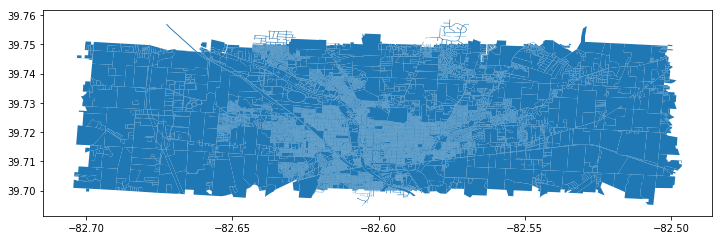

In [68]:
# lancaster
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"] = (12, 10)
fairfield = fairfield.to_crs({'init': 'epsg:4326'})
fairfield[(fairfield.geometry.centroid.x >= -82.7) &
          (fairfield.geometry.centroid.x <= -82.5) &
          (fairfield.geometry.centroid.y >= 39.7) &
          (fairfield.geometry.centroid.y <= 39.75)].plot()


Returning to the task at hand, let's work on cleaning/filtering the Fairfield County data and merging it with the existing data.  

Access to data that was used to construct the GIS dataset is available through a link on the Fairfield County Auditors site. The data is hosted on an external [site](http://downloads.ddti.net/fairfieldoh/) and includes a description of the database structure.  We can load the documentation in the notebook; the description for dwelling data is given on page 13.

In [69]:
IFrame("./data/02-fairfield-description.pdf#page=13", 800, 600)

Based on the first few rows and the documentation, we might be able to filter the data based on the values in the `CLASS` column.  Let's look at its values.

In [70]:
fairfield.CLASS.value_counts()

R    56797
A     7208
C     3573
E     2309
       579
I      316
U       27
Name: CLASS, dtype: int64

We'll assume `R` represents residential data. We can see that we'll likely need the following columns as well.

- `SFLA`: Living area
- `YRBLT`: Year built
- `RMTOT`: Total rooms
- `RMBED`: Bedrooms
- `FIXBATH`: Bathrooms
- `FIXHALF`: Half-bathrooms
- `HEAT`: Heat code
- `PRICE`: Sales price
- `APRLAND`: Appraised land value
- `APRBLDG`: Appraised building value

We can filter the data and extract the columns of interest.

In [76]:
fairfield_columns = ['SFLA', 'YRBLT', 'RMTOT', 'RMBED', 'FIXBATH', 
                     'FIXHALF', 'HEAT', 'PRICE', 'APRLAND',  'APRBLDG']
fairfield_subset = fairfield[fairfield.CLASS == 'R'][fairfield_columns].copy()

Let's look the first few rows of the DataFrame.

In [77]:
fairfield_subset.head()

,SFLA,YRBLT,RMTOT,RMBED,FIXBATH,FIXHALF,HEAT,PRICE,APRLAND,APRBLDG
3,1826,2007,5,3,2,0,3,50000.0,50060.0,144530.0
10,816,1958,4,2,1,0,3,140000.0,28390.0,77190.0
11,2624,2002,8,3,2,1,3,0.0,49180.0,175570.0
17,1384,1900,7,3,1,0,2,0.0,39000.0,64300.0
18,864,1981,4,3,1,0,2,0.0,34050.0,39810.0


We can combine the `FIXBATH` and `FIXHALF` columns into a single column using the same method we used for the Franklin County data.

In [78]:
fairfield_subset['Bathrooms'] = fairfield_subset.FIXBATH + 0.5 * fairfield_subset.FIXHALF
fairfield_subset.drop(["FIXBATH", "FIXHALF"], axis=1, inplace=True)

Turing to the `HEAT` column, the data documentation indicates that the values in this column represent a "heat code".

In [79]:
fairfield_subset.HEAT.value_counts()

3    35346
     10135
2     7350
4     3267
1      699
Name: HEAT, dtype: int64

Among the tables in the database available online is one that defines these values.  The heat codes are as follows:

- 1: None
- 2: Basic
- 3: Air conditioning
- 4: Heat Pump

We'll have to extract both heating and cooling data from this column. Notice that the output of *value_counts()* includes a row count for what appears to be missing data.  Before continuing, let's try to determine why there is a missing value.  To begin, let's use the *unique()* method for a better representation of the distinct values.

In [80]:
fairfield_subset.HEAT.unique() 

array(['3', '2', '', '4', '1'], dtype=object)

The missing value is an empty string.  At this point we need to decide if should assume that a missing value means no heat or some other type of heating that doesn't correspond to a code.  Let's look at a few rows where `HEAT` is an empty string.

<hr>
<a name="Lab-12"></a><mark> **Lab 12** Using a mask and the *head()* method, display the first five rows of `fairfield_subset` where the `HEAT` column has an empty string for a value.

</mark>

In [81]:
fairfield_subset[fairfield_subset.HEAT == ''].head()

,SFLA,YRBLT,RMTOT,RMBED,HEAT,PRICE,APRLAND,APRBLDG,Bathrooms
24,0,0,0,0,,105000.0,33420.0,0.0,0.0
55,0,0,0,0,,48000.0,33670.0,13990.0,0.0
60,0,0,0,0,,0.0,27500.0,9820.0,0.0
61,0,0,0,0,,35000.0,15510.0,0.0,0.0
72,0,0,0,0,,0.0,6470.0,0.0,0.0


<hr>

It appears that records where `HEAT` is an empty string, correspond to parcels with no living area.  At this point we can filter the data again to exclude records with an empty string in `HEAT`.

In [82]:
fairfield_subset = fairfield_subset[fairfield_subset.HEAT != '']

This leaves the following values in the `HEAT` column.

In [83]:
fairfield_subset.HEAT.value_counts()

3    35346
2     7350
4     3267
1      699
Name: HEAT, dtype: int64

While we could write code that iterate through the rows of the DataFrame and sets heating and cooling values at the same time, it is easier to split this into two tasks: set the cooling value then set the heating value. 

We can create a new column, `AirConditioning` based on whether or not `HEAT` has a value of `'3'`. Because the column contains strings, it's important that our masks compare the column's values to another string rather than an iteger, i.e, our mask for air conditioning should be

```python
fairfield_subset.HEAT == '3'
```

rather than

```python
fairfield_subset.HEAT == 3
```


In [84]:
fairfield_subset['AirConditioning'] = fairfield_subset.HEAT == '3'
fairfield_subset.AirConditioning.value_counts()

True     35346
False    11316
Name: AirConditioning, dtype: int64

Similarly, we can assign a new value to `HEAT` based on the existing value. 

In [85]:
fairfield_subset.HEAT = fairfield_subset.HEAT != '1'
fairfield_subset.HEAT.value_counts()

True     45963
False      699
Name: HEAT, dtype: int64

Let's see what the data looks like.

In [89]:
fairfield_subset.head()

,Area,YearBuilt,Rooms,Bedrooms,Heat,SalePrice,AppraisedLand,AppraisedBuilding,Bathrooms,AirConditioning
3,1826,2007,5,3,True,50000.0,50060.0,144530.0,2.0,True
10,816,1958,4,2,True,140000.0,28390.0,77190.0,1.0,True
11,2624,2002,8,3,True,0.0,49180.0,175570.0,2.5,True
17,1384,1900,7,3,True,0.0,39000.0,64300.0,1.0,False
18,864,1981,4,3,True,0.0,34050.0,39810.0,1.0,False


The final steps are to rename the columns, add data about the source, and append the Fairfield subset to our larger dataset.


<hr>
<a name="Lab-13"></a><mark> **Lab 13** In the cell below, rename the columns of the `fairfield_subset` DataFrame so they are consistent with the columns in `home_data`.
</mark>

In [88]:
fairfield_subset.rename(
    {'APRLAND': 'AppraisedLand',
     'APRBLDG': 'AppraisedBuilding',
     'PRICE': 'SalePrice',
     'SFLA': 'Area', 
     'RMTOT':'Rooms',
     'RMBED':'Bedrooms',
     'HEAT': 'Heat',
     'YRBLT': 'YearBuilt'
    },
    axis=1 ,
    inplace=True
)

<hr>

That leaves adding the county name and appending the data.

In [144]:
fairfield_subset['County'] = 'Fairfield'
home_data = home_data.append(fairfield_subset, ignore_index=True)

We can see that our dataset contains data from three counties.

In [145]:
home_data.County.value_counts()

Fairfield    46662
Franklin     35024
Licking       5817
Name: County, dtype: int64

Often when we work with data, we encounter duplication - repetition of data.  We can see if `home_data` contains duplicate data by comparing the number of rows that would be left if we removed duplicates using the *drop_duplicates()* method to the number of rows in the current DataFrame.

In [98]:
len(home_data.drop_duplicates())/len(home_data)

0.9861719026776224

This indicates that a little over 1% of our data corresponds to duplicates.  While the original data might not have contained duplicates, we created what appear to be duplicates by removing unneeded columns.  To see this more clearly, consider the following DataFrame.

In [101]:
df = d1 = pd.DataFrame([[1, 2, 3], [1, 2, 4]], columns=list('ABC'))
df

,A,B,C
0,1,2,3
1,1,2,4


The two rows of data are distinct.  However, if decide we no longer need column `C`, the rows will appear to be duplicates.

In [103]:
df.drop(['C'], axis=1, inplace=True)
df

,A,B
0,1,2
1,1,2


We can calculate the percentage of rows that would be left after removing duplicates as we did above.

In [104]:
len(df.drop_duplicates())/len(df)

0.5

While the rows in `home_data` might have corresponded to distinct properties to begin with, at this point there is no way to distinguish between duplicated rows.  For now, however, we will leave the duplicates in the data knowing that they do represent different properties. 

Let's look at the data types of our columns.

In [118]:
home_data.dtypes

AirConditioning         bool
AppraisedBuilding    float64
AppraisedLand        float64
Area                  object
Bathrooms            float64
Bedrooms             float64
County                object
Fireplaces           float64
Heat                    bool
Rooms                float64
SalePrice            float64
YearBuilt            float64
dtype: object

Notice that `Area` data is stored as objects.  We would probably like to store area as an integer or as a floating point value.  Let's try to convert the area values to integers.

In [155]:
home_data.Area = home_data.Area.astype(int)

ValueError: invalid literal for int() with base 10: '1,790'

The exception message indicates that some of the values contain commas. Before continuing, note the following.

In [165]:
from collections import defaultdict

types = defaultdict(int)
for value in home_data.Area:
    value_type = type(value)
    types[value_type] += 1

types

defaultdict(int, {int: 81686, str: 5817})

The `Area` data contains some data stored as integers and other data stored as strings.  The number of strings corresponds to the number of entries from Licking country so the area data was likely stored with commas in that dataset.  To resolve this we can iterate through each row and, if the data is a string, remove any commas and convert to an integer. To iterate through the rows of a DataFrame we can use *iterrows()*.

In [167]:
for index, row in home_data.iterrows():
    if isinstance(row.Area, str):
        new_value = int(row.Area.replace(",", ''))
        home_data.loc[index, 'Area'] = new_value

Iterating through the DataFrame row by row can be slow and should generally be avoided.  An alternative approach is to create function that would handle one value at a time and use the DataFrame's [*apply()*](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.apply.html) method.

Let's look at the data types for each column now.

In [169]:
home_data.dtypes

AirConditioning         bool
AppraisedBuilding    float64
AppraisedLand        float64
Area                   int64
Bathrooms            float64
Bedrooms             float64
County                object
Fireplaces           float64
Heat                    bool
Rooms                float64
SalePrice            float64
YearBuilt            float64
dtype: object

Now that we've correct the data type for `Area`, lets

In [ ]:
from sqlalchemy import create_engine
engine = create_engine('sqlite:///data/output.sqlite')
home_data.to_sql("home_data", con=engine, if_exists='replace')

## Joining Related Datasets

In [ ]:
# join dataframes
epa_data = pd.read_csv("./data/02-vehicles.csv")

In [ ]:
from IPython.display import HTML
HTML(filename="./data/02-vehicles-description.html")

In [ ]:
epa_data.head()

In [ ]:
sales = pd.read_csv("./data/02-vehicle-sales-norway.csv", encoding="ISO-8859-1")

In [ ]:
sales.head()

In [ ]:
sales.rename({"Model": "MakeModel"}, axis=1, inplace=True)

In [ ]:
# could iterate, should use apply - faster for non-python
def remove_make(row):
    make = row['Make']
    make_model = row['MakeModel']
    return make_model.replace(make, "").strip()
    
sales["Model"] = sales.apply(remove_make, axis=1)

In [ ]:
sales.head()

In [ ]:
sales.rename({col: col.lower() for col in sales.columns},
             axis=1, inplace=True)

In [ ]:
epa_data.merge(sales, on=["year", "make", "model"])

In [ ]:
def strip_lower(x):
    return x.strip().lower()

In [ ]:
epa_models = set(strip_lower(model) for model in epa_data.model)
sales_models = set(strip_lower(model) for model in sales.model)
epa_models.intersection(sales_models)

In [ ]:
epa_makes = set(strip_lower(make) for make in epa_data.make)
sales_makes = set(strip_lower(make) for make in sales.make)
epa_makes.intersection(sales_makes)

In [ ]:
set(epa_data.year).intersection(set(sales.year))

In [ ]:
epa_data.make = epa_data.make.apply(strip_lower)
epa_data.model = epa_data.model.apply(strip_lower)

In [ ]:
sales.make = sales.make.apply(strip_lower)
sales.model = sales.model.apply(strip_lower)

In [ ]:
epa_sales = epa_data.merge(sales, on=["year", "make", "model"])

In [ ]:
epa_sales.head()

In [ ]:
epa_sales.describe()

In [ ]:
epa_sales.to_sql("epa_sales", con=engine, if_exists='replace')

## Lab Answers

1.  ```python
    franklin.PROPTYP.unique()
    ``` 

    or 

    ```python
    franklin.PROPTYP.value_counts()
    ```
2. ```python
   len(franklin_subset) < len(franklin)
   ```
   
3. ```python
   franklin_subset['APPRLND'] = franklin_subset.APPRLND.astype(int)
   franklin_subset = franklin_subset[franklin_subset.APPRLND > 0]
   ```
   
4. ```python
   franklin_subset[['BATHS', 'HBATHS']].dtypes
   ```
   
5. ```python
   franklin_subset.drop(['BATHS', "HBATHS"], axis=1, inplace=True)
   ```
   
6. ```python
   franklin_subset.FIREPLC = franklin_subset.FIREPLC.fillna(value=0)
   ```
   
   or
   
   ```python
   franklin_subset.FIREPLC.fillna(value=0, inplace=True)
   ```
   
7. ```python
   home_data.columns
   ```
   
8. ```python
   display(typical_line.count(";"))
   display(error_line.count(";"))
   ```
   
9. ```python
   [column for column in licking.columns if "area" in column.lower()]
   ```
   
10. ```python
    licking_subset['Bathrooms'] = (licking_subset.fldFullBaths.fillna(0) + 
                                   0.5 * licking_subset.fldHalfBaths.fillna(0) + 
                                   0.25 * licking_subset.fldOtherBaths.fillna(0))
   licking_subset.drop(["fldFullBaths", "fldHalfBaths", "fldOtherBaths"], axis=1, inplace=True)
    ```
    
11. ```python
    licking_subset.fldCooling = licking_subset.fldCooling == "Central"
    ```
    
12. ```python
    fairfield_subset[fairfield_subset.HEAT == ''].head()
    ```
    
13. ```python
    fairfield_subset.rename(
        {'APRLAND': 'AppraisedLand',
         'APRBLDG': 'AppraisedBuilding',
         'PRICE': 'SalePrice',
         'SFLA': 'Area', 
         'RMTOT':'Rooms',
         'RMBED':'Bedrooms',
         'HEAT': 'Heat',
         'YRBLT': 'YearBuilt'
        },
        axis=1 ,
        inplace=True
    )
    ```

## Next Steps

## Resources

- [GeoPandas](http://geopandas.org/)